In [1]:
import torch
import numpy as np
import pandas as pd
import os
import sys
from torch.utils.data import DataLoader, Dataset
from PIL import Image
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


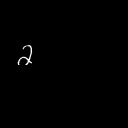

In [2]:
img = Image.open('../../data/external/double_mnist/test/2/0_2.png')

display(img)

In [3]:
img.size

(128, 128)

### load_mnist_data function

In [4]:
def load_mnist_data(dataset_path):
    sets = ['train', 'val', 'test']
    data = {set_type: {'images': [], 'labels': []} for set_type in sets}

    for set_type in sets:
        set_path = os.path.join(dataset_path, set_type)
        
        # Loop through each label directory
        for label in os.listdir(set_path):
            label_path = os.path.join(set_path, label)
            digit_count = len(label)

            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                img = Image.open(img_path)
                data[set_type]['images'].append(img)
                if label != '0':
                    data[set_type]['labels'].append(digit_count)
                else:
                    data[set_type]['labels'].append(0)
                
    return data['train']['images'], data['train']['labels'], data['val']['images'], data['val']['labels'], data['test']['images'], data['test']['labels']


### Data Loader class

In [26]:
class MultiMNISTDataset:
    def __init__(self, images, labels, transform = None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def get_data(self):

        # if self.transform:
        #     img = []
        #     for image in self.images:
        #         img.append(self.transform(image))
        #     return img,self.labels
        
        return self.images, self.labels
    
    def __getitem__(self, index):
        img = self.images[index]
        label = self.labels[index]

        if self.transform:
            img = self.transform(img)

        return img, label

In [29]:
def create_data_loaders(path):
    train_images, train_labels, val_images, val_labels, test_images, test_labels = load_mnist_data(path)

    transform = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Resize((28,28)),
        transforms.Normalize(mean=[0], std=[1])
    ])

    train_data = MultiMNISTDataset(train_images, train_labels, transform)
    val_data = MultiMNISTDataset(val_images, val_labels, transform)
    test_data = MultiMNISTDataset(test_images, test_labels, transform)

    trainLoader = DataLoader(train_data, batch_size=32, shuffle = True)
    valLoader = DataLoader(val_data, batch_size=32, shuffle = False)
    testLoader = DataLoader(test_data, batch_size=32, shuffle = True)

    return trainLoader, valLoader, testLoader



In [7]:
path = '../../data/external/double_mnist'
trainLoader, valLoader, testLoader = create_data_loaders(path)

### CNN class

In [ ]:
class cnn(nn.Module):
    def __init__(self, input_channels=1, 
                 conv_layers=[32,64], 
                 kernel_size=[5,5], 
                 dense_layers=[128,32],
                 input_size=(128,128),
                 activation = 'relu',
                 model="classifier",
                 num_classes=4
                 ):
        super(cnn, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model

        self.conv_layers = nn.ModuleList()
        self.kernel_sizes = kernel_size
        self.batchnorm_layers = nn.ModuleList()
        self.activation = activation
        
        self.conv_layers.append(nn.Conv2d(in_channels=input_channels,
                                          out_channels=conv_layers[0],
                                          kernel_size=kernel_size[0],
                                          padding='same'))
        self.batchnorm_layers.append(nn.BatchNorm2d(conv_layers[0]))

        for i in range(1,len(conv_layers)):
            self.conv_layers.append(nn.Conv2d(in_channels=conv_layers[i-1],
                                              out_channels=conv_layers[i],
                                              kernel_size=kernel_size[i],
                                              padding='same'))
            self.batchnorm_layers.append(nn.BatchNorm2d(conv_layers[i]))

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        h, w = input_size

        for _ in range(len(conv_layers)):
            h = h//2
            w = w//2

        flattened_size = conv_layers[-1] * h* w

        self.fc_layers = nn.ModuleList()
        self.fc_layers.append(nn.Linear(in_features=flattened_size,
                                        out_features=dense_layers[0],
                                        ))
        
        for i in range(1,len(dense_layers)):
            self.fc_layers.append(nn.Linear(in_features=dense_layers[i-1],
                                            out_features=dense_layers[i]))
            
        if self.model == 'classifier':
            self.output_layer = nn.Linear(dense_layers[-1], num_classes)
        else:
            self.output_layer = nn.Linear(dense_layers[-1],1)

        self.dropout = nn.Dropout(0.5)

        self.to(self.device)

    def activation_layer(self, x):
        if self.activation == "relu":
            return F.relu(x) 
        elif self.activation == "sigmoid":
            return F.sigmoid(x)
        elif self.activation == "tanh":
            return F.tanh(x)
        else:
            return x

    def forward(self, x):
        feature_maps = []
        x=x.to(self.device)

        for conv,bn in zip(self.conv_layers, self.batchnorm_layers):
            x = conv(x)
            x = bn(x)
            x = self.activation_layer(x)
            x = self.pool(x)
            feature_maps.append(x)

        x = x.view(x.size(0), -1)

        for i, dense in enumerate(self.fc_layers):
            x = dense(x)
            x = self.activation_layer(x)
            if i < len(self.fc_layers) - 1:
                x = self.dropout(x)

        x = self.output_layer(x)
        self.featuremaps = feature_maps

        return x
    
    def get_loss_function(self):
        if self.model == 'classifier':
            return nn.CrossEntropyLoss()
        
        else:
            return nn.MSELoss()
        
    def train_model(self, trainLoader, valLoader, epochs=10, learning_rate=0.01, 
                patience=5, min_delta=0.001):
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        criterion = self.get_loss_function()

        train_losses = []
        val_losses = []
        
        best_val_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(epochs):
            self.train()
            epoch_loss = 0.0
            
            for i, (images, labels) in enumerate(trainLoader):
                optimizer.zero_grad()
                images = images.to(self.device)
                labels = labels.to(self.device)

                if self.model == 'regressor':
                    labels = labels.float()

                outputs = self(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            epoch_loss = epoch_loss / len(trainLoader)
            train_losses.append(epoch_loss)
            
            epoch_val_loss, correct, total = self.eval_val(valLoader)
            val_losses.append(epoch_val_loss)
            
            if self.model == 'classifier':
                accuracy = 100 * correct / total
                print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_loss:.4f}, '
                    f'Val Loss: {epoch_val_loss:.4f}, Accuracy: {accuracy:.2f}%')
            else:
                print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_loss:.4f}, '
                    f'Val Loss: {epoch_val_loss:.4f}')
            
            if epoch_val_loss < best_val_loss - min_delta:
                best_val_loss = epoch_val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                print(f'Early stopping counter: {patience_counter}/{patience}')
                
                if patience_counter >= patience:
                    if epoch+1<epochs:
                        print(f'\nEarly stopping triggered after epoch {epoch+1}')
                    break
        
        return train_losses,val_losses
    
    def eval_val(self, loader):
        self.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        criterion = self.get_loss_function()
        
        with torch.no_grad():
            for batch_X, batch_y in loader:
                batch_X = batch_X.to(self.device)
                batch_y = batch_y.to(self.device)

                if self.model != 'classifier':
                    batch_y = batch_y.view(-1, 1)
                
                if self.model == 'regressor':
                    batch_y = batch_y.float()

                outputs = self(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                
                if self.model == 'classifier':
                    _, predicted = torch.max(outputs.data, 1)
                    total += batch_y.size(0)
                    correct += (predicted == batch_y).sum().item()

        return val_loss/len(loader), correct, total
    
    def visualize_feature_map(self, image):
        # Set model to evaluation mode
        self.eval()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(device)
        image = image.unsqueeze(0).to(device)  # Add batch dimension

        # Forward pass to get feature maps
        feature_maps = []
        x = image
        with torch.no_grad():
            self.forward(x)
        feature_maps = self.featuremaps            

        # Plot feature maps
        num_layers = len(feature_maps)
        num_cols = 4  # Set number of columns for subplot layout
        fig, axes = plt.subplots(num_layers, num_cols, figsize=(12, num_layers * 3))

        for layer_idx, fmap in enumerate(feature_maps):
            fmap = fmap.cpu().detach().numpy()  # Move to CPU and convert to NumPy array
            num_features = fmap.shape[1]  # Number of feature maps

            for i in range(min(num_features, 8)):  # Plot up to 8 feature maps
                ax = axes[layer_idx, i] if num_layers > 1 else axes[i]  # Handle single-layer case
                ax.imshow(fmap[0, i], cmap='viridis')  # Show the first sample in the batch
                ax.axis('off')
                ax.set_title(f'Layer {layer_idx + 1} - Feature Map {i + 1}')

            # Turn off any remaining axes for this row
            for j in range(i + 1, num_cols):
                if num_layers > 1:
                    axes[layer_idx, j].axis('off')
                else:
                    axes[j].axis('off')

        plt.tight_layout()
        plt.show()

### Function for training the CNN (Classification)

In [9]:
def train_model(model, trainLoader, valLoader, epochs=10, learning_rate=0.01, 
                patience=5, min_delta=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = model.get_loss_function()

    train_losses = []
    val_losses = []
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        
        for i, (images, labels) in enumerate(trainLoader):
            optimizer.zero_grad()
            images = images.to(model.device)
            labels = labels.to(model.device)

            if model.model == 'regressor':
                labels = labels.float()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_loss = epoch_loss / len(trainLoader)
        train_losses.append(epoch_loss)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch_X, batch_y in valLoader:
                batch_X = batch_X.to(model.device)
                batch_y = batch_y.to(model.device)

                if model.model != 'classifier':
                    batch_y = batch_y.view(-1, 1)
                
                if model.model == 'regressor':
                    batch_y = batch_y.float()

                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                
                if model.model == 'classifier':
                    _, predicted = torch.max(outputs.data, 1)
                    total += batch_y.size(0)
                    correct += (predicted == batch_y).sum().item()
        
        epoch_val_loss = val_loss / len(valLoader)
        val_losses.append(epoch_val_loss)
        
        if model.model == 'classifier':
            accuracy = 100 * correct / total
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_loss:.4f}, '
                  f'Val Loss: {epoch_val_loss:.4f}, Accuracy: {accuracy:.2f}%')
        else:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_loss:.4f}, '
                  f'Val Loss: {epoch_val_loss:.4f}')
        
        if epoch_val_loss < best_val_loss - min_delta:
            best_val_loss = epoch_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            print(f'Early stopping counter: {patience_counter}/{patience}')
            
            if patience_counter >= patience:
                if epoch+1<epochs:
                    print(f'\nEarly stopping triggered after epoch {epoch+1}')
                break
    
    return train_losses,val_losses

In [9]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [13]:
def evaluate_test_set(model, testLoader):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for images, labels in testLoader:
            images = images.to(model.device)
            labels = labels.to(model.device)
            
            outputs = model(images)
            
            if model.model == 'classifier':
                _, predicted = torch.max(outputs.data, 1)
                predictions.extend(predicted.cpu().numpy())
                actuals.extend(labels.cpu().numpy())
            else:
                outputs = torch.round(outputs)
                predictions.extend(outputs.cpu().numpy())
                actuals.extend(labels.cpu().numpy())

    return predictions, actuals


## CNN 1
2 convolution layers with output sizes 32 and 64, Followed by dense layers with 128 and 32 neurons respectively. Learning rate of 0.01.

In [43]:
cnn1 = cnn(conv_layers=[32,64], kernel_size=[3,5], dense_layers=[128,32],
                input_size=(128,128), model='classifier', num_classes=4)

train_loss, val_loss = cnn1.train_model(trainLoader, valLoader)


Epoch [1/10], Train Loss: 0.8624, Val Loss: 2.6237, Accuracy: 79.60%
Epoch [2/10], Train Loss: 0.1380, Val Loss: 0.0117, Accuracy: 99.80%
Epoch [3/10], Train Loss: 0.1129, Val Loss: 0.0044, Accuracy: 99.87%
Epoch [4/10], Train Loss: 0.0920, Val Loss: 0.7285, Accuracy: 83.73%
Early stopping counter: 1/5
Epoch [5/10], Train Loss: 0.0802, Val Loss: 0.0057, Accuracy: 100.00%
Early stopping counter: 2/5
Epoch [6/10], Train Loss: 0.0872, Val Loss: 0.0374, Accuracy: 96.67%
Early stopping counter: 3/5
Epoch [7/10], Train Loss: 0.0625, Val Loss: 0.0009, Accuracy: 100.00%
Epoch [8/10], Train Loss: 0.0616, Val Loss: 0.0019, Accuracy: 100.00%
Early stopping counter: 1/5
Epoch [9/10], Train Loss: 0.0349, Val Loss: 0.0005, Accuracy: 100.00%
Early stopping counter: 2/5
Epoch [10/10], Train Loss: 0.0788, Val Loss: 0.0005, Accuracy: 100.00%
Early stopping counter: 3/5


In [44]:
pred,actual = evaluate_test_set(cnn1, testLoader)

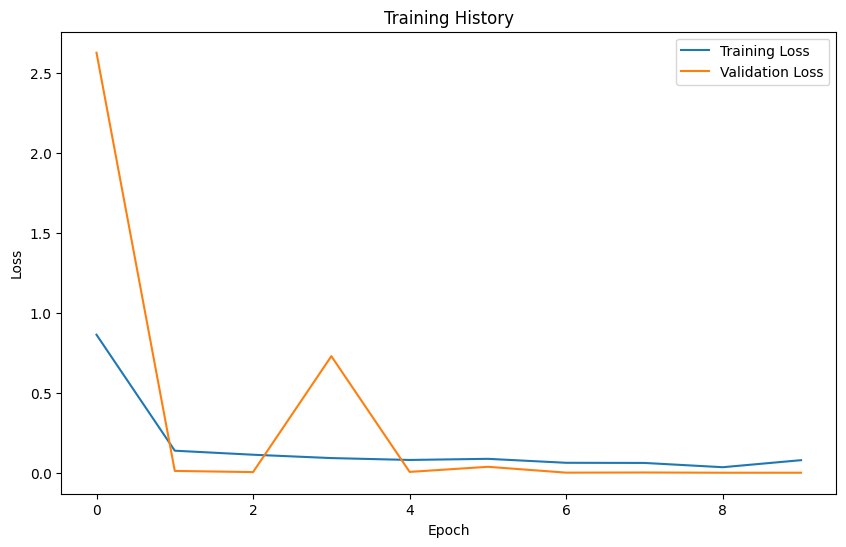

In [45]:
plot_training_history(train_loss,val_loss)

In [46]:
accuracy = 0
for i in range(len(pred)):
    if pred[i]==actual[i]:
        accuracy+=1
accuracy/=len(pred)
accuracy

1.0

/home/samkit/anaconda3/envs/normal/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/samkit/anaconda3/envs/normal/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10], Train Loss: 115.8071, Val Loss: 1.5489
Epoch [2/10], Train Loss: 0.7426, Val Loss: 1.5240
Epoch [3/10], Train Loss: 0.6355, Val Loss: 1.6468
Early stopping counter: 1/5
Epoch [4/10], Train Loss: 0.6299, Val Loss: 1.5345
Early stopping counter: 2/5
Epoch [5/10], Train Loss: 0.6248, Val Loss: 1.4664
Epoch [6/10], Train Loss: 0.6169, Val Loss: 1.5009
Early stopping counter: 1/5
Epoch [7/10], Train Loss: 0.6131, Val Loss: 1.6320
Early stopping counter: 2/5
Epoch [8/10], Train Loss: 0.6064, Val Loss: 1.5351
Early stopping counter: 3/5
Epoch [9/10], Train Loss: 0.6087, Val Loss: 1.6147
Early stopping counter: 4/5
Epoch [10/10], Train Loss: 0.6060, Val Loss: 1.6431
Early stopping counter: 5/5


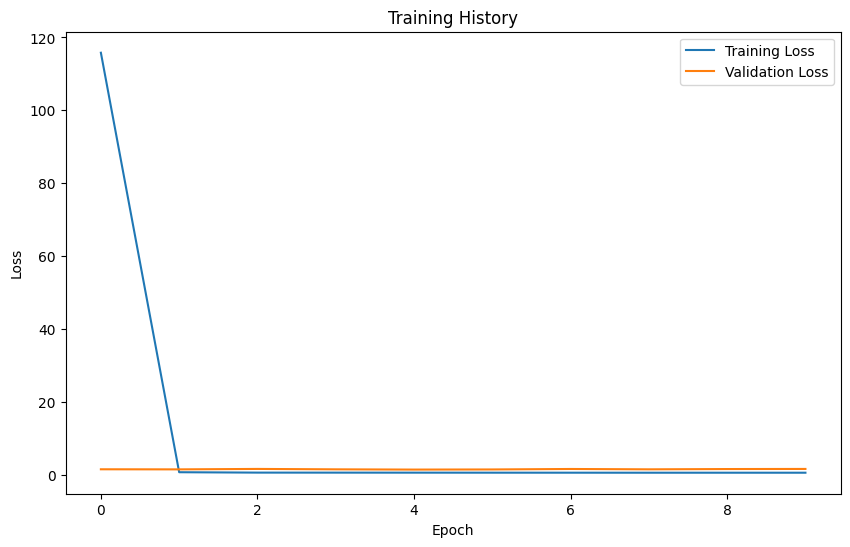

0.32608695652173914

In [17]:
cnn1_reg = cnn(conv_layers=[32,64], kernel_size=[3,5], dense_layers=[128,32],
                input_size=(128,128), model='regressor', num_classes=4)

train_loss, val_loss = cnn1_reg.train_model(trainLoader, valLoader)
pred, actual = evaluate_test_set(cnn1_reg, testLoader)
plot_training_history(train_loss,val_loss)
accuracy = 0
for i in range(len(pred)):
    if pred[i]==actual[i]:
        accuracy+=1
accuracy/=len(pred)
accuracy

## CNN 2
1 convolution layer with output sizes 32, Followed by dense layers 32. Learning rate of 0.01.

In [18]:
cnn2 = cnn(conv_layers=[32], kernel_size=[5], dense_layers=[32],
                input_size=(128,128), model='classifier', num_classes=4)

train_loss, val_loss = cnn2.train_model(trainLoader, valLoader)

Epoch [1/10], Train Loss: 0.7635, Val Loss: 0.0287, Accuracy: 98.93%
Epoch [2/10], Train Loss: 0.1272, Val Loss: 0.0761, Accuracy: 97.97%
Early stopping counter: 1/5
Epoch [3/10], Train Loss: 0.0522, Val Loss: 0.3328, Accuracy: 93.70%
Early stopping counter: 2/5
Epoch [4/10], Train Loss: 0.0238, Val Loss: 0.0047, Accuracy: 99.90%
Epoch [5/10], Train Loss: 0.0886, Val Loss: 0.0578, Accuracy: 98.93%
Early stopping counter: 1/5
Epoch [6/10], Train Loss: 0.1105, Val Loss: 0.0043, Accuracy: 99.93%
Early stopping counter: 2/5
Epoch [7/10], Train Loss: 0.0099, Val Loss: 0.0191, Accuracy: 99.63%
Early stopping counter: 3/5
Epoch [8/10], Train Loss: 0.0124, Val Loss: 0.0698, Accuracy: 96.50%
Early stopping counter: 4/5
Epoch [9/10], Train Loss: 0.0246, Val Loss: 0.0025, Accuracy: 99.90%
Epoch [10/10], Train Loss: 0.0051, Val Loss: 0.0013, Accuracy: 99.97%


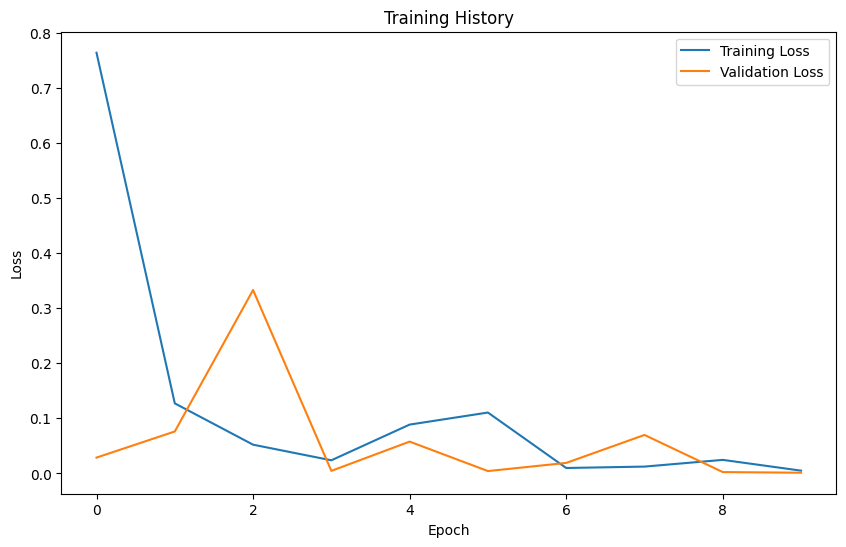

In [19]:
pred,actual = evaluate_test_set(cnn2, testLoader)
plot_training_history(train_loss,val_loss)

In [20]:
accuracy = 0
for i in range(len(pred)):
    if pred[i]==actual[i]:
        accuracy+=1
accuracy/=len(pred)
accuracy

0.996304347826087

/home/samkit/anaconda3/envs/normal/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/samkit/anaconda3/envs/normal/lib/python3.8/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10], Train Loss: 463.1356, Val Loss: 3.7888
Epoch [2/10], Train Loss: 2.9750, Val Loss: 2.4634
Epoch [3/10], Train Loss: 1.8327, Val Loss: 1.4585
Epoch [4/10], Train Loss: 1.1047, Val Loss: 0.9029
Epoch [5/10], Train Loss: 0.7619, Val Loss: 0.6700
Epoch [6/10], Train Loss: 0.6444, Val Loss: 0.5955
Epoch [7/10], Train Loss: 0.6159, Val Loss: 0.5760
Epoch [8/10], Train Loss: 0.6110, Val Loss: 0.5711
Epoch [9/10], Train Loss: 0.6108, Val Loss: 0.5697
Epoch [10/10], Train Loss: 0.6105, Val Loss: 0.5700
Early stopping counter: 1/5


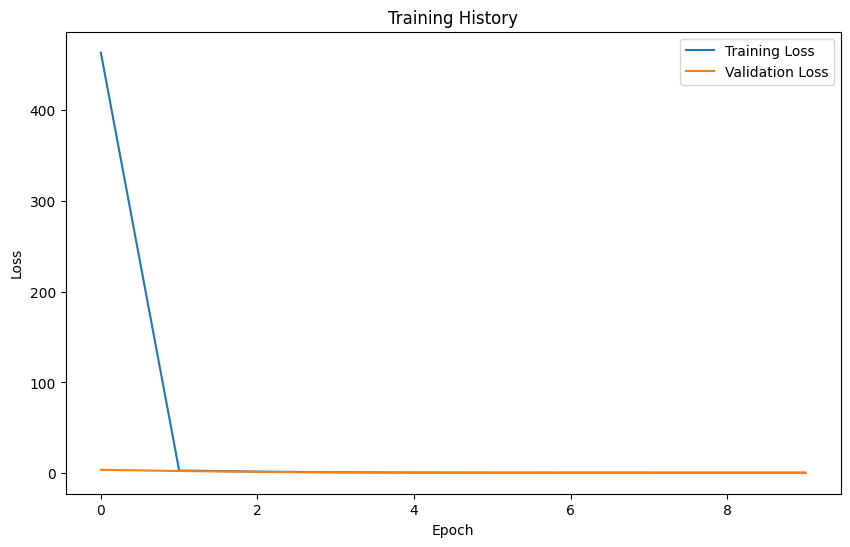

0.43478260869565216

In [21]:
cnn2_reg = cnn(conv_layers=[32], kernel_size=[5], dense_layers=[32],
                input_size=(128,128), model='regressor')

train_loss, val_loss = cnn2_reg.train_model(trainLoader, valLoader)
pred,actual = evaluate_test_set(cnn2_reg, testLoader)
plot_training_history(train_loss,val_loss)
accuracy = 0
for i in range(len(pred)):
    if pred[i]==actual[i]:
        accuracy+=1
accuracy/=len(pred)
accuracy

## CNN 3
2 convolution layers with output sizes 32 and 128, Followed by dense layers with 32 and 64 neurons respectively. Learning rate of 0.1.

In [22]:
cnn3 = cnn(conv_layers=[32,128], kernel_size=[5,5], dense_layers=[32,64],
                input_size=(128,128), model='classifier', num_classes=4)

train_loss, val_loss = cnn3.train_model(trainLoader, valLoader, learning_rate=0.1)

Epoch [1/10], Train Loss: 7.6295, Val Loss: 1.1044, Accuracy: 53.33%
Epoch [2/10], Train Loss: 1.1472, Val Loss: 1.1004, Accuracy: 53.33%
Epoch [3/10], Train Loss: 1.1461, Val Loss: 1.1127, Accuracy: 53.33%
Early stopping counter: 1/5
Epoch [4/10], Train Loss: 1.1490, Val Loss: 1.1051, Accuracy: 53.33%
Early stopping counter: 2/5
Epoch [5/10], Train Loss: 1.1476, Val Loss: 1.1093, Accuracy: 53.33%
Early stopping counter: 3/5
Epoch [6/10], Train Loss: 1.1468, Val Loss: 1.1068, Accuracy: 53.33%
Early stopping counter: 4/5
Epoch [7/10], Train Loss: 1.1478, Val Loss: 1.1090, Accuracy: 53.33%
Early stopping counter: 5/5

Early stopping triggered after epoch 7


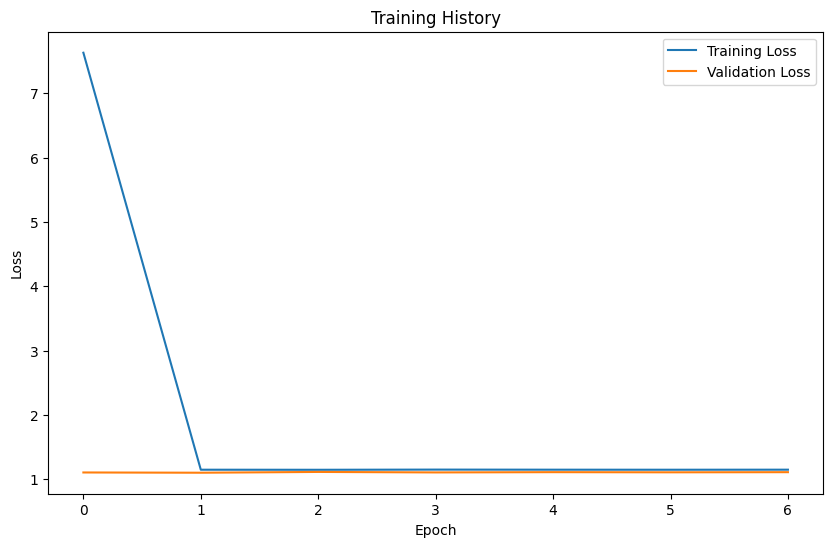

0.43478260869565216

In [23]:
pred,actual = evaluate_test_set(cnn3, testLoader)
plot_training_history(train_loss,val_loss)
accuracy = 0
for i in range(len(pred)):
    if pred[i]==actual[i]:
        accuracy+=1
accuracy/=len(pred)
accuracy

Epoch [1/10], Train Loss: 1028137.2415, Val Loss: 6.4772
Epoch [2/10], Train Loss: 5.9351, Val Loss: 5.8258
Epoch [3/10], Train Loss: 5.2133, Val Loss: 5.0104
Epoch [4/10], Train Loss: 4.3775, Val Loss: 4.1194
Epoch [5/10], Train Loss: 3.5120, Val Loss: 3.2355
Epoch [6/10], Train Loss: 2.6936, Val Loss: 2.4319
Epoch [7/10], Train Loss: 1.9883, Val Loss: 1.7670
Epoch [8/10], Train Loss: 1.4361, Val Loss: 1.2678
Epoch [9/10], Train Loss: 1.0499, Val Loss: 0.9340
Epoch [10/10], Train Loss: 0.8130, Val Loss: 0.7376


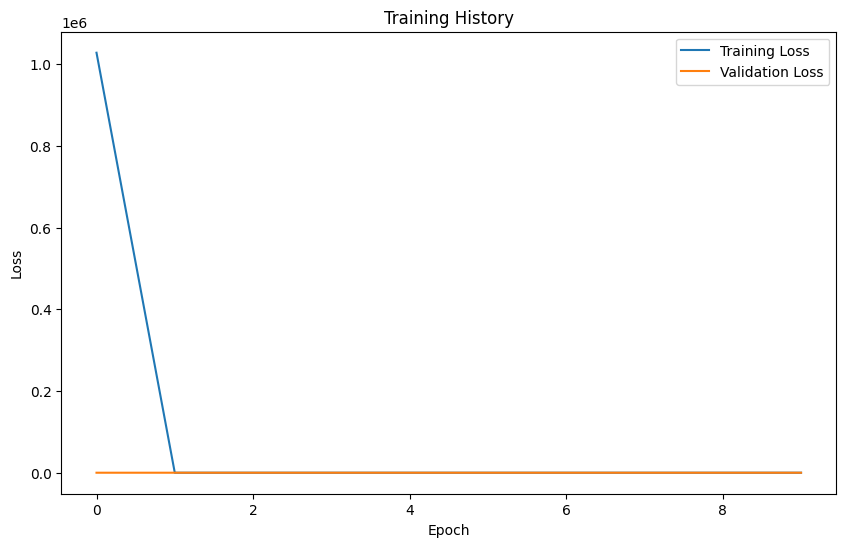

0.43478260869565216

In [24]:
cnn3_reg = cnn(conv_layers=[32,128], kernel_size=[5,5], dense_layers=[32,64],
                input_size=(128,128), model='regressor')

train_loss, val_loss = cnn3_reg.train_model(trainLoader, valLoader, learning_rate=0.1)
pred,actual = evaluate_test_set(cnn3_reg, testLoader)
plot_training_history(train_loss,val_loss)
accuracy = 0
for i in range(len(pred)):
    if pred[i]==actual[i]:
        accuracy+=1
accuracy/=len(pred)
accuracy

## CNN 4
2 convolution layers with output sizes 32 and 128, Followed by dense layers with 32 and 64 neurons respectively. Learning rate of 0.01.

In [ ]:
cnn4 = cnn(conv_layers=[32,128], kernel_size=[5,5], dense_layers=[32,64],
                input_size=(128,128), model='classifier', num_classes=4)

train_loss, val_loss = cnn4.train_model(trainLoader, valLoader, learning_rate=0.01)

Epoch [1/10], Train Loss: 1.5348, Val Loss: 1.1102, Accuracy: 53.33%
Validation loss improved to 1.1102
Epoch [2/10], Train Loss: 1.1427, Val Loss: 1.1047, Accuracy: 53.33%
Validation loss improved to 1.1047
Epoch [3/10], Train Loss: 1.1427, Val Loss: 1.1036, Accuracy: 53.33%
Validation loss improved to 1.1036
Epoch [4/10], Train Loss: 1.1430, Val Loss: 1.1027, Accuracy: 53.33%
Early stopping counter: 1/5
Epoch [5/10], Train Loss: 1.1429, Val Loss: 1.1065, Accuracy: 53.33%
Early stopping counter: 2/5
Epoch [6/10], Train Loss: 1.1429, Val Loss: 1.1118, Accuracy: 53.33%
Early stopping counter: 3/5
Epoch [7/10], Train Loss: 1.1432, Val Loss: 1.1075, Accuracy: 53.33%
Early stopping counter: 4/5
Epoch [8/10], Train Loss: 1.1423, Val Loss: 1.1049, Accuracy: 53.33%
Early stopping counter: 5/5

Early stopping triggered after epoch 8


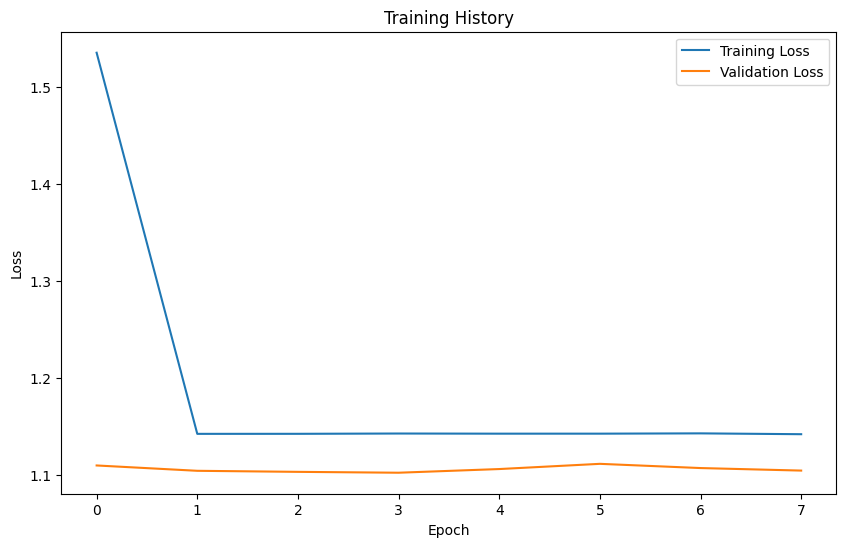

0.43478260869565216

In [26]:
pred,actual = evaluate_test_set(cnn4, testLoader)
plot_training_history(train_loss,val_loss)
accuracy = 0
for i in range(len(pred)):
    if pred[i]==actual[i]:
        accuracy+=1
accuracy/=len(pred)
accuracy

In [ ]:
cnn4_reg = cnn(conv_layers=[32,128], kernel_size=[5,5], dense_layers=[32,64],
                input_size=(128,128), model='regressor')

train_loss, val_loss = cnn4_reg.train_model(trainLoader, valLoader, learning_rate=0.01)
pred,actual = evaluate_test_set(cnn4_reg, testLoader)
plot_training_history(train_loss,val_loss)
accuracy = 0
for i in range(len(pred)):
    if pred[i]==actual[i]:
        accuracy+=1
accuracy/=len(pred)
accuracy

## CNN 5
1 convolution layers with output sizes 64. Followed by dense layers with 64 neurons. Learning rate of 0.01.

In [ ]:
cnn5 = cnn(conv_layers=[64], kernel_size=[5], dense_layers=[64],
                input_size=(128,128), model='classifier', num_classes=4)

train_loss, val_loss = cnn5.train_model(trainLoader, valLoader, learning_rate=0.01)

Epoch [1/10], Train Loss: 1.6066, Val Loss: 1.5790, Accuracy: 79.17%
Validation loss improved to 1.5790
Epoch [2/10], Train Loss: 0.1168, Val Loss: 0.0980, Accuracy: 96.83%
Validation loss improved to 0.0980
Epoch [3/10], Train Loss: 0.0709, Val Loss: 0.0229, Accuracy: 99.73%
Validation loss improved to 0.0229
Epoch [4/10], Train Loss: 0.0524, Val Loss: 0.0277, Accuracy: 99.47%
Early stopping counter: 1/5
Epoch [5/10], Train Loss: 0.0873, Val Loss: 0.1196, Accuracy: 98.97%
Early stopping counter: 2/5
Epoch [6/10], Train Loss: 0.0514, Val Loss: 0.1991, Accuracy: 98.73%
Early stopping counter: 3/5
Epoch [7/10], Train Loss: 0.1135, Val Loss: 0.0959, Accuracy: 99.53%
Early stopping counter: 4/5
Epoch [8/10], Train Loss: 0.1047, Val Loss: 0.0889, Accuracy: 99.50%
Early stopping counter: 5/5

Early stopping triggered after epoch 8


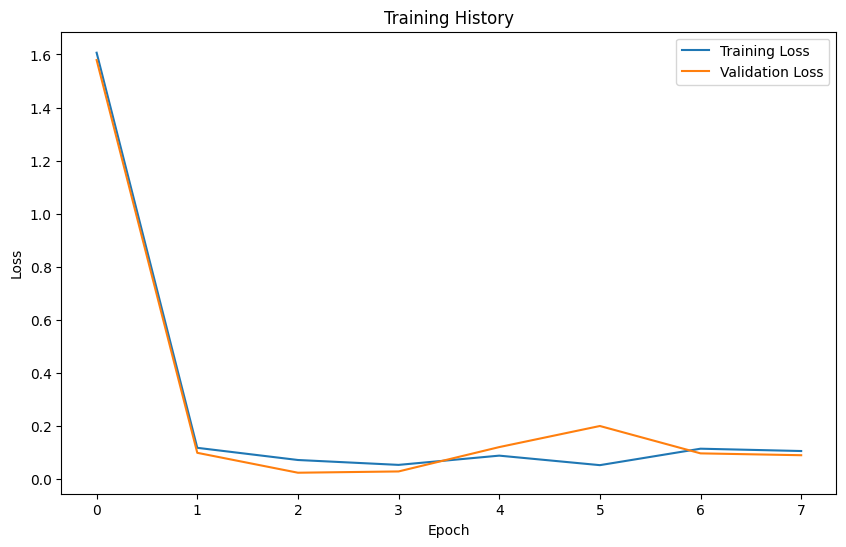

0.9954347826086957

In [28]:
pred,actual = evaluate_test_set(cnn5, testLoader)
plot_training_history(train_loss,val_loss)
accuracy = 0
for i in range(len(pred)):
    if pred[i]==actual[i]:
        accuracy+=1
accuracy/=len(pred)
accuracy

In [ ]:
cnn5_reg = cnn(conv_layers=[64], kernel_size=[5], dense_layers=[64],
                input_size=(128,128), model='regressor')

train_loss, val_loss = cnn5_reg.train_model(trainLoader, valLoader, learning_rate=0.01)
pred,actual = evaluate_test_set(cnn5_reg, testLoader)
plot_training_history(train_loss,val_loss)
accuracy = 0
for i in range(len(pred)):
    if pred[i]==actual[i]:
        accuracy+=1
accuracy/=len(pred)
accuracy

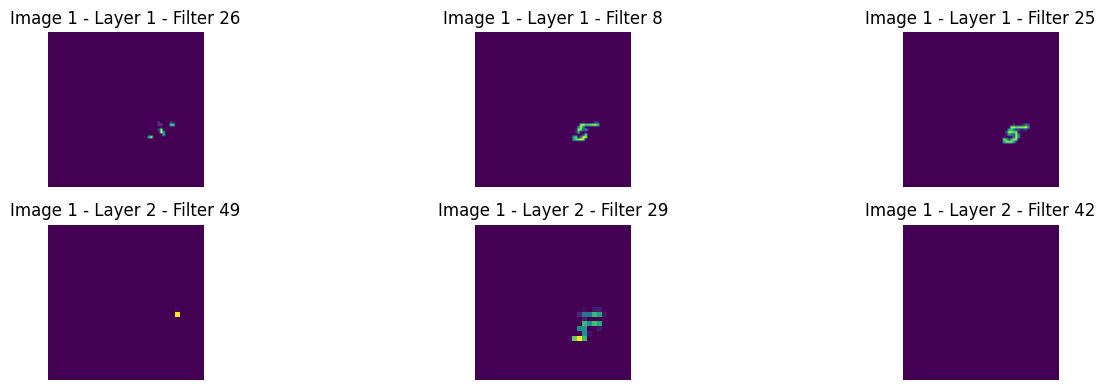

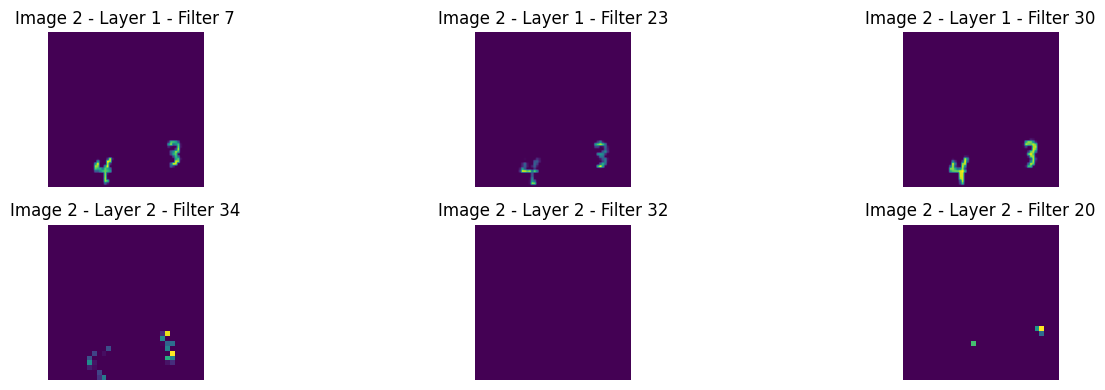

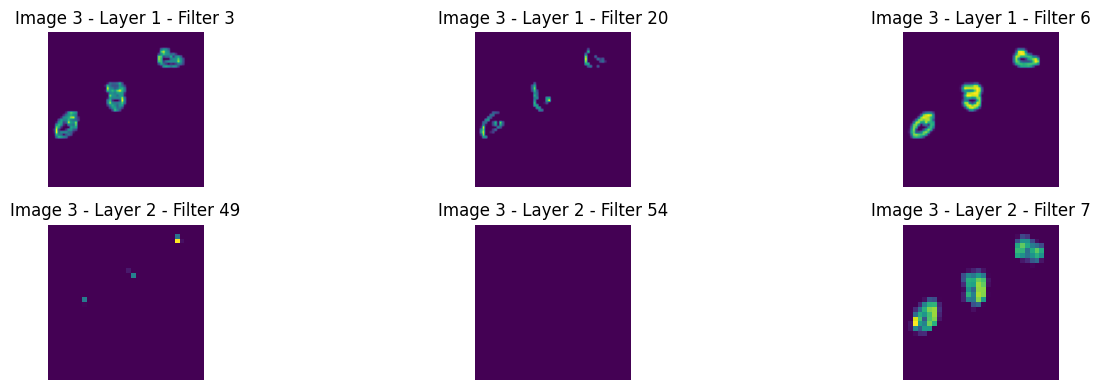

In [47]:
import torch
import matplotlib.pyplot as plt
import random

images_train, train_labels, val_images, val_labels, test_images, test_labels = load_mnist_data(path)

img_arrays = [np.array(img) for img in images_train]

images_train = np.stack(img_arrays) 

random_indices = random.sample(range(len(images_train)), 3)

# Loop through the selected images
for idx, img_idx in enumerate(random_indices):
    # Convert the image at the selected index to a PyTorch tensor with float32 type
    image = torch.tensor(images_train[img_idx], dtype=torch.float32)
    
    # If the image is grayscale, add batch and channel dimensions
    if image.ndim == 2:
        image = image.unsqueeze(0)  # Add channel dimension: [C, H, W]
        image = image.unsqueeze(0)  # Add batch dimension: [1, C, H, W]

    # Send the image to GPU if available
    image = image.to("cuda")

    # Pass the image through the CNN model
    _ = cnn1.forward(image)
    
    # Move feature maps to CPU for visualization
    feature_maps = [fmap.cpu().detach().numpy() for fmap in cnn1.featuremaps]

    # Determine figure size based on the number of layers and filters
    num_layers = len(feature_maps)
    num_filters = 3  # Show 3 random filters for each layer
    fig, axes = plt.subplots(num_layers, num_filters, figsize=(15, num_layers * 2))
    
    # Plot random filters for each layer
    for layer_idx, fmap in enumerate(feature_maps):
        # Get the number of filters in this layer
        total_filters = fmap.shape[1]
        
        # Randomly select three filter indices
        random_filters = random.sample(range(total_filters), num_filters)
        
        for i, filter_idx in enumerate(random_filters):
            # Plot the selected random filter
            axes[layer_idx, i].imshow(fmap[0, filter_idx], cmap='viridis')  # Display the first sample in batch
            axes[layer_idx, i].axis('off')
            axes[layer_idx, i].set_title(f'Image {idx + 1} - Layer {layer_idx + 1} - Filter {filter_idx + 1}')

    # Adjust layout and show the figure
    plt.tight_layout()
    plt.show()
